In [86]:
# install Catboost
! pip install catboost

In [87]:
# Load libraries
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd

# **Data Cleaning/Preprocessing**

In [88]:
# Load dataset and drop unneeded columns
df_2018=pd.read_csv('/content/drive/MyDrive/cleaned_2018_bk (2).csv')
df_2018.drop(['Unnamed: 0', 	'Sample',	'Richness',	'OTU_per_sample',	'serial2', 'Serial'], inplace=True, axis=1)
df_2018.drop(['LONG', 'LAT', 'Point_ID'], axis=1, inplace=True)
df_2018.dropna(subset=['N'], inplace=True)
df_2018.fillna(0, inplace=True)

<ipython-input-88-612a549d6545>:2: DtypeWarning: Columns (1,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2018=pd.read_csv('/content/drive/MyDrive/cleaned_2018_bk (2).csv')


In [89]:
# Fill < LOD values with 0
for i in ['P', 'N', 'K', 'CaCO3', 'OC']:
  df_2018[i].replace('< LOD', 0, inplace=True)
  df_2018[i].replace('<0.0', 0, inplace=True)
  df_2018[i].replace('<  LOD', 0, inplace=True)
  df_2018[i]=df_2018[i].astype('float64')

In [90]:
# Label encode the variables
cat= ['Country', 'Land Cover', 'Depth',  'Land Description' ]
import pickle
for i in cat:
  le= LabelEncoder()
  name= i +  '.pkl'
  output = open(name, 'wb')
  df_2018[i]=le.fit_transform(df_2018[i])
  pickle.dump(le, output)
  output.close()


# **Managed VS Unmanaged LUCAS 2018**

In [91]:
# Classification of Land Use to managed and Unmanaged
dict_={'Forestry': 'Managed',
 'Agriculture (excluding fallow land and kitchen gardens)': 'Managed',
 'Semi-natural and natural areas not in use': 'Unmanaged',
 'Construction': 'Managed',
 'Residential': 'Managed',
 'Road transport': 'Managed',
 'Other abandoned areas': 'Unmanaged',
 'Energy production': 'Managed',
 'Electricity, gas and thermal power distribution': 'Managed',
 'Fallow land': 'Unmanaged',
 'Amenities, museum, leisure (e.g. parks, botanical gardens)': 'Managed',
 'Kitchen gardens': 'Managed',
 'Railway transport': 'Managed',
 'Financial, professional and information services': 'Managed',
 'Protection infrastructures': 'Managed',
 'Commerce': 'Managed',
 'Mining and quarrying': 'Managed',
 'Sport': 'Managed',
 'Community services': 'Managed',
 'Water supply and treatment': 'Managed',
 'Other primary production': 'Unmanaged',
 'Abandoned residential areas': 'Unmanaged',
 'Logistics and storage': 'Managed',
 'Abandoned industrial areas': 'Unmanaged',
 'Water transport': 'Unmanaged',
 'Abandoned transport areas': 'Unmanaged'}

# Label encode the land use classifications {'Managed':0, 'Unmanaged':1}
df_2018_manage_class=df_2018.copy()
df_2018_manage_class['Land Use']=df_2018_manage_class['Land Use'].map(dict_)
df_2018_manage_class['Land Use']=df_2018_manage_class['Land Use'].map({'Managed':0, 'Unmanaged':1})

In [92]:
# Split to dependent and independent variables
X= df_2018_manage_class.drop(['Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev'], axis=1)
Y=df_2018_manage_class['Land Use']
# split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
# Build classifier
rf=RandomForestClassifier(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', f1_score(y_test, yhat))

gb=GradientBoostingClassifier()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', f1_score(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBClassifier()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', f1_score(y_test, yhat) )

from catboost import CatBoostClassifier
ct= CatBoostClassifier(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', f1_score(y_test, yhat) )

from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', f1_score(y_test, yhat) )

Random 0.6173541963015647
Gb 0.6173541963015647
Xgb 0.6352941176470589
cat 0.6476964769647696
dt 0.525564803804994


In [ ]:
# Save best classifier(catboost) for deployment
from catboost import CatBoostClassifier
ct= CatBoostClassifier(verbose=0)
ct.fit(X, Y)
ct.save_model('Managed_Unmanged')

# **Environmentally Impacted VS Non_Environmentally Impacted LUCAS 2018**

In [10]:
# Classification of Land Use to environmentally impacted and non environmentally impacted
dict_={'Forestry': 'Environmentally Impacted',
 'Agriculture (excluding fallow land and kitchen gardens)': 'Environmentally Impacted',
 'Semi-natural and natural areas not in use': 'Non Environmentally Impacted',
 'Construction': 'Environmentally Impacted',
 'Residential': 'Non Environmentally Impacted',
 'Road transport': 'Environmentally Impacted',
 'Other abandoned areas': 'Environmentally Impacted',
 'Energy production': 'Environmentally Impacted',
 'Electricity, gas and thermal power distribution': 'Environmentally Impacted',
 'Fallow land': 'Non Environmentally Impacted',
 'Amenities, museum, leisure (e.g. parks, botanical gardens)': 'Non Environmentally Impacted',
 'Kitchen gardens': 'Non Environmentally Impacted',
 'Railway transport': 'Environmentally Impacted',
 'Financial, professional and information services': 'Non Environmentally Impacted',
 'Protection infrastructures': 'Non Environmentally Impacted',
 'Commerce': 'Non Environmentally Impacted',
 'Mining and quarrying': 'Environmentally Impacted',
 'Sport': 'Non Environmentally Impacted',
 'Community services': 'Non Environmentally Impacted',
 'Water supply and treatment': 'Environmentally Impacted',
 'Other primary production': 'Non Environmentally Impacted',
 'Abandoned residential areas': 'Environmentally Impacted',
 'Logistics and storage': 'Non Environmentally Impacted',
 'Abandoned industrial areas': 'Environmentally Impacted',
 'Water transport': 'Non Environmentally Impacted',
 'Abandoned transport areas': 'Environmentally Impacted'}

# label encode land use Environmentally Impacted':1, 'Non Environmentally Impacted':0
df_2018_Env_impacted_class=df_2018.copy()
df_2018_Env_impacted_class['Land Use']=df_2018_Env_impacted_class['Land Use'].map(dict_)
df_2018_Env_impacted_class['Land Use']=df_2018_Env_impacted_class['Land Use'].map({'Environmentally Impacted':1, 'Non Environmentally Impacted':0})

In [11]:
# Split to dependent and independent variables
X= df_2018_Env_impacted_class.drop(['Land Use','NUTS_1', 'NUTS_2', 'NUTS_3', 'elev'], axis=1)
Y=df_2018_Env_impacted_class['Land Use']
# Split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
# Build Classifier
rf=RandomForestClassifier(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', f1_score(y_test, yhat))

gb=GradientBoostingClassifier()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', f1_score(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBClassifier()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', f1_score(y_test, yhat) )

from catboost import CatBoostClassifier
ct= CatBoostClassifier(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', f1_score(y_test, yhat) )

from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', f1_score(y_test, yhat) )

Random 0.9564838990426457
Gb 0.9564838990426457
Xgb 0.9571574791636205
cat 0.9587042171311834
dt 0.9355174981384959


In [ ]:
 # Save best Model for deployment
ct= CatBoostClassifier(verbose=0)
ct.fit(X, Y)
ct.save_model('Environmental impact')

# **Fungi Diversity Prediction**

In [93]:
# Load fungi dataset
df_=pd.read_csv('/content/drive/MyDrive/cleaned_2018_bk (2).csv')
df_.dropna(subset=['N'], inplace=True)
df_=df_.loc[:895]
df_=df_[['Richness', 'OTU_per_sample' ]]
df_2018_=df_2018.loc[:895]
df_2018_fungi=pd.concat([df_2018_, df_], axis=1)

<ipython-input-93-6b804e23d425>:2: DtypeWarning: Columns (1,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_=pd.read_csv('/content/drive/MyDrive/cleaned_2018_bk (2).csv')


**Fungi Richness**

In [95]:
# Split to dependent and independent
X=df_2018_fungi.drop(['Richness', 'OTU_per_sample', 'Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev'], axis=1)
Y=df_2018_fungi['Richness']
# Split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
# Build regressor model for fungi Richness prediction
rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

gb=GradientBoostingRegressor()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 780.7918644067795
Gb 810.0661644107869
Xgb 844.6306142860886
cat 824.8625779444471
dt 1026.3446327683616


In [ ]:
# save best model
rf=RandomForestRegressor(random_state=20)
rf.fit(X, Y)
output = open('fungi_rich.pkl', 'wb')
pickle.dump(rf, output)
output.close()

**Fungi Abundance**

In [16]:
# Split to dependent and independent
X=df_2018_fungi.drop(['Richness', 'OTU_per_sample', 'Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev'], axis=1)
Y=df_2018_fungi['OTU_per_sample']
# Split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Build regressor model for fungi abundance prediction
rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

gb=GradientBoostingRegressor()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 14.106949152542375
Gb 13.774721952358096
Xgb 15.849303504167978
cat 14.42428251523237
dt 18.423728813559322


In [ ]:
#Save best model
rf=RandomForestRegressor(random_state=20)
rf.fit(X, Y)
output = open('fungi_abd.pkl', 'wb')
pickle.dump(rf, output)
output.close()

# **Bacteria Diversity Prediction**

In [71]:
# Merging and cleaning data for bacteria richness and abundance prediction
df__=df_2018_fungi.drop_duplicates('elev')
df2=pd.read_csv('/content/drive/MyDrive/bac_OTU.csv')
df1=pd.read_csv('/content/drive/MyDrive/PRJNA952168_metadata.csv')[['Run', 'elev']]
df3=df1.merge(df2, left_on='Run', right_on='SRR_code', how='inner').drop_duplicates(subset=['elev'])
df_bact=df3.merge(df__, left_on='elev', right_on='elev', how='inner').drop_duplicates(subset=['Run'])

**Bacteria Richness**

In [ ]:
# Split to dependent and independent
X=df_bact.drop(['Run', 'Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev', 'SRR_code', 'bacOTUs_per_sample',\
               'bac_abundance', 'Richness', 'OTU_per_sample' ], axis=1)
Y=df_bact['bacOTUs_per_sample']
# Split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Build regressor model for bacteria richness prediction
rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

rf=GradientBoostingRegressor()
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 206.12398148148148
Gb 208.41924797422078
Xgb 229.82217244748716
cat 212.7947893942983
dt 291.93518518518516


In [ ]:
#save best model
rf=GradientBoostingRegressor()
rf.fit(X, Y)
output = open('bact_rich.pkl', 'wb')
pickle.dump(rf, output)
output.close()

**Bacteria Abundanc**e

In [ ]:
# Split to dependent and target features
X=df_bact.drop(['Run', 'Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev', 'SRR_code', 'bacOTUs_per_sample',\
               'bac_abundance', 'Richness', 'OTU_per_sample' ], axis=1)
Y=df_bact['bac_abundance']
# split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Build regressor model for bacteria abundance prediction
rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

rf=GradientBoostingRegressor()
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 9551.016203703704
Gb 9394.09692845902
Xgb 11197.868408203125
cat 9674.459766380054
dt 15350.444444444445


In [ ]:
# Save best model
gb=GradientBoostingRegressor()
gb.fit(X, Y)
output = open('bact_abd.pkl', 'wb')
pickle.dump(gb, output)
output.close()

# **Microbial Diversity in Predicting Carbon Content**

In [ ]:
# Encode Land Use
cat= ['Land Use' ]

for i in cat:
  le= LabelEncoder()
  df_bact[i]=le.fit_transform(df_bact[i])

In [ ]:
# Split to dependent and target features
X=df_bact.drop(['Run', 'Land Use', 'NUTS_1', 'NUTS_2', 'NUTS_3', 'elev', 'SRR_code', 'OC' ], axis=1)
Y=df_bact['OC']
X=X.rename(columns={'Richness': 'Fungi_abundance', 'OTU_per_sample': 'FungiOTU_per_sample'})

In [ ]:
# With Microbial Diversity Features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)


rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

gb=GradientBoostingRegressor()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 7.118499999999996
Gb 7.118499999999996
Xgb 8.114407950860482
cat 7.2704484609951745
dt 10.058333333333334


Text(0.5, 0, 'Relative Importance')

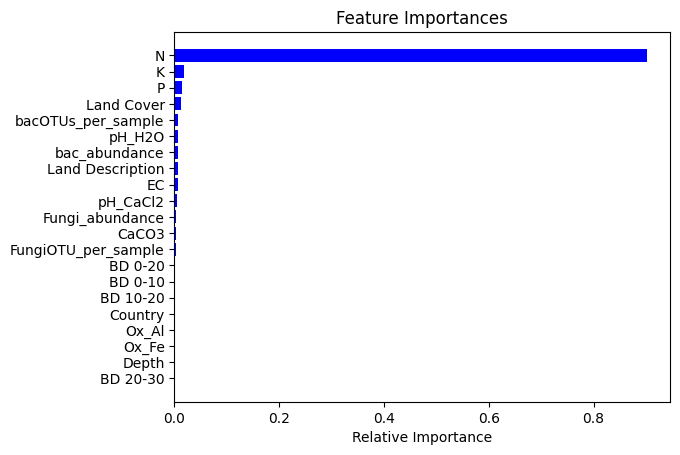

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
features=X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
# Without Microbial Diversity Features
X=X.drop(['bacOTUs_per_sample', 'bac_abundance', 'Fungi_abundance', 'FungiOTU_per_sample'], axis=1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)


rf=RandomForestRegressor(random_state=20)
rf.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Random', mean_absolute_error(y_test, yhat))

gb=GradientBoostingRegressor()
gb.fit(X_train, y_train)
yhat=rf.predict(X_test)
print('Gb', mean_absolute_error(y_test, yhat) )

import xgboost as xg
xgb_r = xg.XGBRegressor()
xgb_r.fit(X_train, y_train)
yhat=xgb_r.predict(X_test)
print('Xgb', mean_absolute_error(y_test, yhat) )

from catboost import CatBoostRegressor
ct= CatBoostRegressor(verbose=0)
ct.fit(X_train, y_train)
yhat=ct.predict(X_test)
print ('cat', mean_absolute_error(y_test, yhat) )

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print('dt', mean_absolute_error(y_test, yhat) )

Random 6.89975925925926
Gb 6.89975925925926
Xgb 8.520341770737259
cat 7.787718401772183
dt 10.164814814814816
